## Traininig the Inclusive classifier with tf.keras using data in TFRecord format

**tf.keras Inclusive classifier** This notebooks trains a dense neural network for the particle classifier using the Inclusive Classifier, using as input the full list of recunstructed particles and the High Level Features. Data is prepared in TFRecord format converting from Parquet using Apache Spark. Tensorflow data procesing uses tf.data and tf.io.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow-gpu 2.0.0-rc0
* *Platform*: CentOS 7.6, Cuda 10, Python 3.6
* GPU: Tesla P100

## Create the Keras model for the inclusive classifier

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

In [2]:
tf.version.VERSION

'2.0.0-rc0'

In [3]:
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

In [ ]:
## GRU branch
gru_input = Input(shape=(801,19), name='gru_input')
a = gru_input
a = Masking(mask_value=0.)(a)
a = GRU(units=50,activation='tanh')(a)
gruBranch = Dropout(0.2)(a)

In [5]:
hlf_input = Input(shape=(14), name='hlf_input')
b = hlf_input
hlfBranch = Dropout(0.2)(b)

In [6]:
c = concatenate([gruBranch, hlfBranch])
c = Dense(25, activation='relu')(c)
output = Dense(3, activation='softmax')(c)

In [7]:
model = Model(inputs=[gru_input, hlf_input], outputs=output)

In [8]:
## Compile model
optimizer = 'Adam'
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )
    

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 801, 19)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 801, 19)      0           gru_input[0][0]                  
__________________________________________________________________________________________________
gru (GRU)                       (None, 50)           10650       masking[0][0]                    
__________________________________________________________________________________________________
hlf_input (InputLayer)          [(None, 14)]         0                                            
______________________________________________________________________________________________

## Load test and training data in TFRecord format, using tf.data and tf.io

In [10]:
# test dataset 
PATH = "<..PATH..>/testUndersampled.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", shuffle=False)

# training dataset 
PATH = "<..PATH..>/trainUndersampled.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", seed=4242)

In [11]:
# tunable
num_parallel_reads=tf.data.experimental.AUTOTUNE # TF2.0
# num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [13]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [14]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
# Show and example of the parsed data
for record in parsed_test_dataset.take(1):
    print(record)

((<tf.Tensor: id=2229, shape=(801, 19), dtype=float32, numpy=
array([[ 6.4023461e+00, -1.4673073e+00, -1.6204217e-01, ...,
         0.0000000e+00, -3.5355341e-02, -2.1870793e-03],
       [ 2.6258626e+00, -5.5381924e-01, -6.8641043e-01, ...,
         0.0000000e+00, -3.5355341e-02, -2.1870793e-03],
       [ 8.1321602e+00, -2.6328623e+00, -1.8198299e+00, ...,
         0.0000000e+00, -3.5355341e-02, -2.1870793e-03],
       ...,
       [-1.3195525e-01,  1.2554147e+00,  8.4996206e-01, ...,
         0.0000000e+00, -3.5355341e-02, -2.1870793e-03],
       [ 2.0994931e-02,  1.6978103e+00,  1.2966487e+00, ...,
         0.0000000e+00, -3.5355341e-02, -2.1870793e-03],
       [ 4.0385714e+00,  1.5981019e+01,  1.1523566e+01, ...,
         0.0000000e+00,  2.8284271e+01,  1.7496635e+00]], dtype=float32)>, <tf.Tensor: id=2230, shape=(14,), dtype=float32, numpy=
array([1.6655369e-02, 6.8869051e-03, 5.6183463e-01, 4.4570133e-06,
       1.3333334e-01, 1.2500000e-01, 1.3353462e-04, 7.4619615e-01,
       5.8

In [16]:
# tunable
batch_size=128

train=parsed_train_dataset.repeat().batch(batch_size)

In [17]:
steps_per_epoch=3426083//batch_size  # there are 3426083 samples in the training dataset
steps_per_epoch

26766

In [18]:
# tunable
validation_batch_size=1024

test=parsed_test_dataset.repeat().batch(validation_batch_size)

In [19]:
validation_steps=856090//validation_batch_size  # there are 856090 samples in the test dataset
validation_steps

836

## Train the tf.keras model

In [20]:
# train the Keras model

# tunable
num_epochs = 8

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, steps_per_epoch=steps_per_epoch, \
                          validation_data=test, validation_steps=validation_steps, \
                          epochs=num_epochs, callbacks=callbacks, verbose=1)


Train for 26766 steps, validate for 836 steps
Epoch 1/8
26766/26766 [==============================] - 1777s 66ms/step - loss: 0.2421 - accuracy: 0.9098 - val_loss: 0.1724 - val_accuracy: 0.9364
Epoch 2/8
26766/26766 [==============================] - 1771s 66ms/step - loss: 0.1723 - accuracy: 0.9372 - val_loss: 0.1458 - val_accuracy: 0.9474
Epoch 3/8
26766/26766 [==============================] - 1771s 66ms/step - loss: 0.1488 - accuracy: 0.9463 - val_loss: 0.1283 - val_accuracy: 0.9536
Epoch 4/8
26766/26766 [==============================] - 1781s 67ms/step - loss: 0.1366 - accuracy: 0.9508 - val_loss: 0.1245 - val_accuracy: 0.9555
Epoch 5/8
26766/26766 [==============================] - 1772s 66ms/step - loss: 0.1315 - accuracy: 0.9529 - val_loss: 0.1201 - val_accuracy: 0.9569
Epoch 6/8
26766/26766 [==============================] - 1775s 66ms/step - loss: 0.1285 - accuracy: 0.9541 - val_loss: 0.1185 - val_accuracy: 0.9578
Epoch 7/8
26766/26766 [==============================] - 177

## Performance metrics

<IPython.core.display.Javascript object>


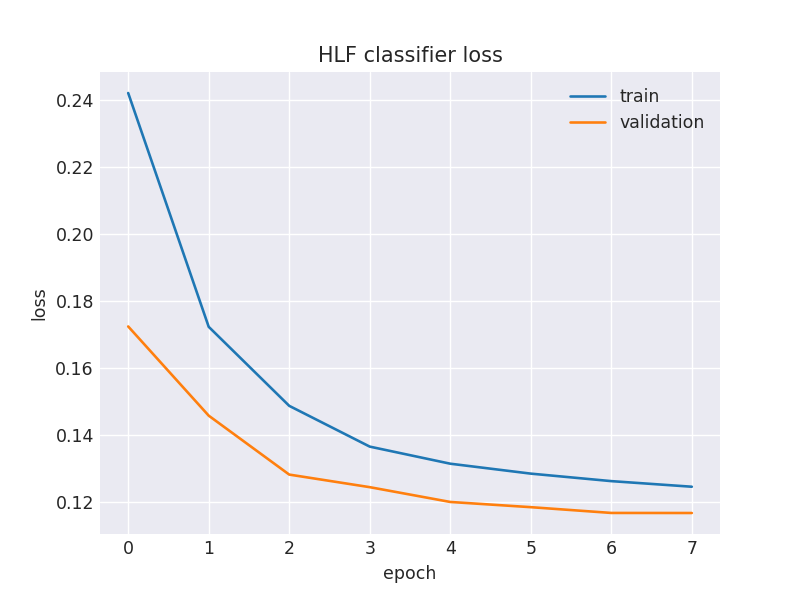

In [28]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


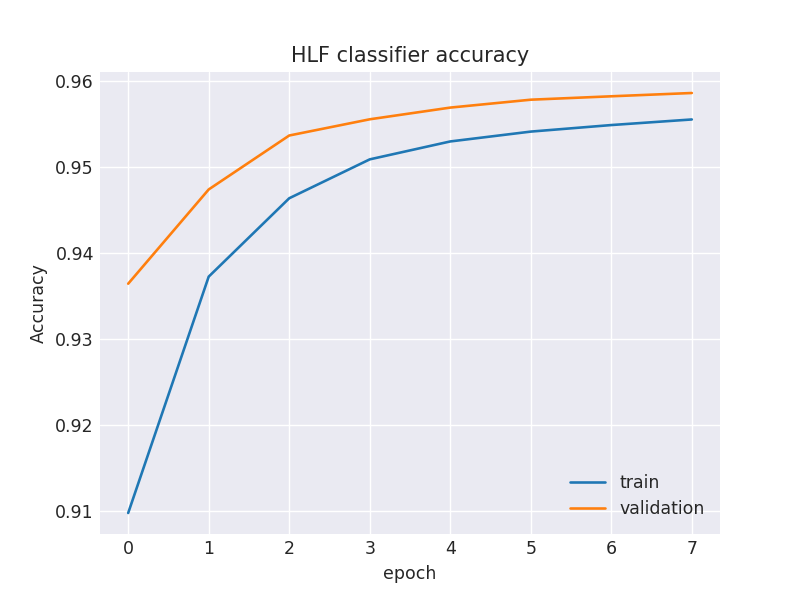

In [29]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [23]:
y_pred = history.model.predict(test, steps=validation_steps)
num_entries=y_pred[:,0].size

In [24]:
y_test_all = [labels.numpy() for features,labels in parsed_test_dataset.__iter__()]

In [25]:
y_true = np.stack(y_test_all[:num_entries])

In [26]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9586


<IPython.core.display.Javascript object>


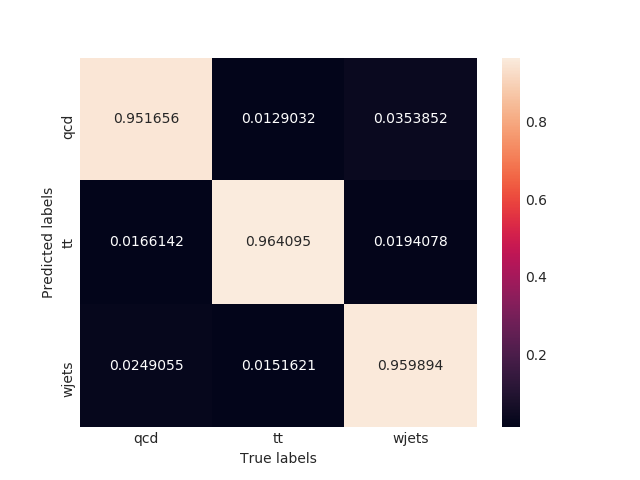

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [30]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [31]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9953912111011292, 1: 0.9970093740307626, 2: 0.9950085364817652}

<IPython.core.display.Javascript object>


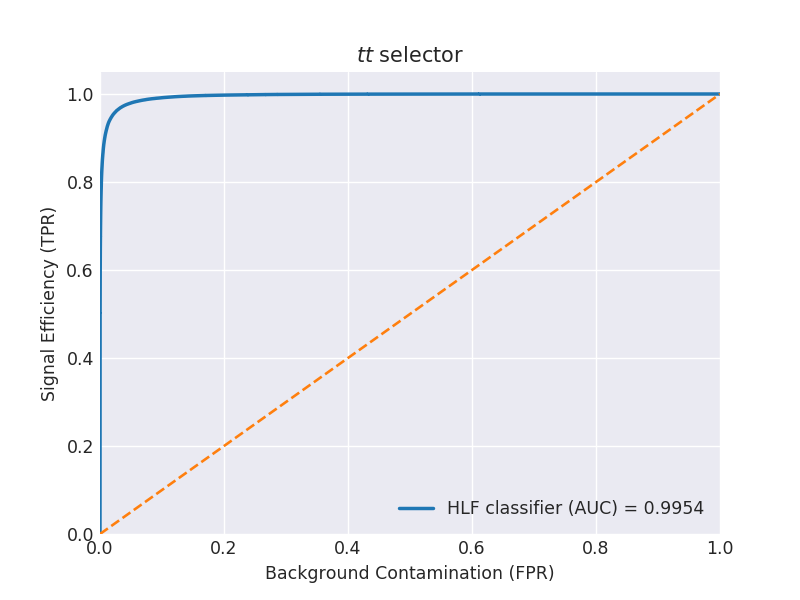

In [32]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()